In [1]:
import sys
import math
import torch
import matplotlib.pyplot as plt
from datasets import Dataset
from collections import defaultdict
from torch.utils.data import DataLoader
from transformers import LlamaTokenizer, LlamaForCausalLM
from baukit import TraceDict, nethook
from einops import rearrange, einsum
from tqdm import tqdm

sys.path.append("../")
from data.data_utils import *
from experiment_1.pp_utils import compute_prev_query_box_pos

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 5
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

/home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Evaluation Data

In [3]:
tokenizer = LlamaTokenizer.from_pretrained(
    "hf-internal-testing/llama-tokenizer", padding_side="right"
)
tokenizer.pad_token_id = tokenizer.eos_token_id

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
data_file = "../data/dataset.jsonl"
batch_size = 1

raw_data = sample_box_data(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file,
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 500


## Loading Model and Tokenizer

In [5]:
path = "/home/local_nikhil/Projects/llama_weights/7B"

model = LlamaForCausalLM.from_pretrained(path).to(device)
tokenizer = LlamaTokenizer.from_pretrained(
    "hf-internal-testing/llama-tokenizer", padding_side="right"
)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


## Overriding Attention Mechanism

In [6]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [7]:
def apply_causal_mask(attn_scores, layer, from_pos, to_pos):
    ignore = torch.tensor(torch.finfo(attn_scores.dtype).min)
    mask = torch.triu(
        torch.ones(
            attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device
        ),
        diagonal=1,
    ).bool()
    attn_scores.masked_fill_(mask, ignore)

    # Attention knockout
    attn_scores[:, :, from_pos, to_pos] = ignore

    return attn_scores

In [8]:
def intervention_wrapper(batch_size, seq_len, from_pos, to_pos):
    def attention_knockout(inputs, output, layer):
        if "norm" in layer:
            return output
        global queries, keys, attn_outputs
        n_heads = model.config.num_attention_heads
        d_model = model.config.hidden_size
        d_head = d_model // n_heads
        layer_index = int(layer.split(".")[2])

        if "q_proj" in layer:
            query = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            queries[layer_index] = query

        elif "k_proj" in layer:
            key = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            keys[layer_index] = key

        elif "v_proj" in layer:
            value = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            key = keys[layer_index]
            query = queries[layer_index]

            kv_seq_len = key.shape[-2]
            cos, sin = model.model.layers[layer_index].self_attn.rotary_emb(
                value, seq_len=kv_seq_len
            )
            positions = [i for i in range(seq_len)]
            positions = (
                torch.tensor(positions).unsqueeze(0).repeat(batch_size, 1).to(device)
            )
            query, key = apply_rotary_pos_emb(query, key, cos, sin, positions)

            attn_scores = einsum(
                key,
                query,
                "batch n_heads key_pos d_head, batch n_heads query_pos d_head -> batch n_heads query_pos key_pos",
            )
            attn_scores = attn_scores / math.sqrt(d_head)
            attn_scores = apply_causal_mask(attn_scores, layer, from_pos, to_pos)
            attn_scores = torch.softmax(attn_scores, dim=-1)
            attn_output = einsum(
                attn_scores,
                value,
                "batch n_heads query_pos key_pos, batch n_heads key_pos d_head -> batch query_pos n_heads d_head",
            )
            attn_output = attn_output.reshape(batch_size, seq_len, d_model)
            attn_outputs[layer_index] = attn_output

        elif "o_proj" in layer:
            attn_output = attn_outputs[layer_index]
            o_proj_weight = model.state_dict()[f"{layer}.weight"]
            output = einsum(
                attn_output,
                o_proj_weight,
                "batch seq_len d_model, hidden_size d_model -> batch seq_len hidden_size",
            )
            return output
        else:
            return output

    return attention_knockout

## Knocking out attention from last position to correct object token position

In [8]:
accuracies = defaultdict(float)
for knockout_layer in range(0, model.config.num_hidden_layers):
    modules = [
        [
            f"model.layers.{i}.self_attn.k_proj",
            f"model.layers.{i}.self_attn.q_proj",
            f"model.layers.{i}.self_attn.v_proj",
            f"model.layers.{i}.self_attn.o_proj",
        ]
        for i in range(knockout_layer, model.config.num_hidden_layers)
    ]

    modules = [item for sublist in modules for item in sublist]
    queries, keys, attn_outputs = {}, {}, {}

    model.eval()
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, input in enumerate(dataloader):
            for k, v in input.items():
                if v is not None and isinstance(v, torch.Tensor):
                    input[k] = v.to(model.device)

            batch_size, seq_len = input["input_ids"].shape
            prev_box_label_index = compute_prev_query_box_pos(
                input["input_ids"][0], input["last_token_indices"][0]
            )
            correct_obj_pos = prev_box_label_index - 4

            with TraceDict(
                model,
                modules,
                retain_output=True,
                edit_output=intervention_wrapper(
                    batch_size,
                    seq_len,
                    from_pos=input["last_token_indices"][0],
                    to_pos=correct_obj_pos,
                ),
            ) as _:
                outputs = model(input_ids=input["input_ids"])

            for bi in range(input["labels"].size(0)):
                label = input["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][input["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    accuracies[knockout_layer+1] = round(correct_count / total_count, 2)

    print(f"Knockout Starting Layer {knockout_layer} acc: {accuracies[knockout_layer+1]}")

Knockout Starting Layer 0 acc: 0.04
Knockout Starting Layer 1 acc: 0.04
Knockout Starting Layer 2 acc: 0.04
Knockout Starting Layer 3 acc: 0.04
Knockout Starting Layer 4 acc: 0.04
Knockout Starting Layer 5 acc: 0.04
Knockout Starting Layer 6 acc: 0.04
Knockout Starting Layer 7 acc: 0.04
Knockout Starting Layer 8 acc: 0.04
Knockout Starting Layer 9 acc: 0.04
Knockout Starting Layer 10 acc: 0.04
Knockout Starting Layer 11 acc: 0.04
Knockout Starting Layer 12 acc: 0.04
Knockout Starting Layer 13 acc: 0.04
Knockout Starting Layer 14 acc: 0.04
Knockout Starting Layer 15 acc: 0.04
Knockout Starting Layer 16 acc: 0.06
Knockout Starting Layer 17 acc: 0.07
Knockout Starting Layer 18 acc: 0.07
Knockout Starting Layer 19 acc: 0.13
Knockout Starting Layer 20 acc: 0.21
Knockout Starting Layer 21 acc: 0.25
Knockout Starting Layer 22 acc: 0.41
Knockout Starting Layer 23 acc: 0.41
Knockout Starting Layer 24 acc: 0.56
Knockout Starting Layer 25 acc: 0.6
Knockout Starting Layer 26 acc: 0.61
Knockout Sta

In [9]:
with open("results/from_last_to_correct_obj_pos.json", "w") as f:
    json.dump(accuracies, f)

## Knocking out attention from last position to random token position

In [10]:
accuracies = defaultdict(float)
for knockout_layer in range(0, model.config.num_hidden_layers):
    modules = [
        [
            f"model.layers.{i}.self_attn.k_proj",
            f"model.layers.{i}.self_attn.q_proj",
            f"model.layers.{i}.self_attn.v_proj",
            f"model.layers.{i}.self_attn.o_proj",
        ]
        for i in range(knockout_layer, model.config.num_hidden_layers)
    ]

    modules = [item for sublist in modules for item in sublist]
    queries, keys, attn_outputs = {}, {}, {}

    model.eval()
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, input in enumerate(dataloader):
            for k, v in input.items():
                if v is not None and isinstance(v, torch.Tensor):
                    input[k] = v.to(model.device)

            batch_size, seq_len = input["input_ids"].shape
            # Selecting random position in the prompt context (not in the query)
            to_pos = random.randint(0, seq_len - 4)

            with TraceDict(
                model,
                modules,
                retain_output=True,
                edit_output=intervention_wrapper(
                    batch_size,
                    seq_len,
                    from_pos=input["last_token_indices"][0],
                    to_pos=to_pos,
                ),
            ) as _:
                outputs = model(input_ids=input["input_ids"])

            for bi in range(input["labels"].size(0)):
                label = input["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][input["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    accuracies[knockout_layer+1] = round(correct_count / total_count, 2)

    print(f"Knockout Starting Layer {knockout_layer} acc: {accuracies[knockout_layer+1]}")

Knockout Starting Layer 0 acc: 0.63
Knockout Starting Layer 1 acc: 0.63
Knockout Starting Layer 2 acc: 0.64
Knockout Starting Layer 3 acc: 0.64
Knockout Starting Layer 4 acc: 0.63
Knockout Starting Layer 5 acc: 0.63
Knockout Starting Layer 6 acc: 0.65
Knockout Starting Layer 7 acc: 0.63
Knockout Starting Layer 8 acc: 0.63
Knockout Starting Layer 9 acc: 0.62
Knockout Starting Layer 10 acc: 0.63
Knockout Starting Layer 11 acc: 0.64
Knockout Starting Layer 12 acc: 0.64
Knockout Starting Layer 13 acc: 0.64
Knockout Starting Layer 14 acc: 0.65
Knockout Starting Layer 15 acc: 0.63
Knockout Starting Layer 16 acc: 0.63
Knockout Starting Layer 17 acc: 0.64
Knockout Starting Layer 18 acc: 0.64
Knockout Starting Layer 19 acc: 0.65
Knockout Starting Layer 20 acc: 0.64
Knockout Starting Layer 21 acc: 0.63
Knockout Starting Layer 22 acc: 0.65
Knockout Starting Layer 23 acc: 0.64
Knockout Starting Layer 24 acc: 0.65
Knockout Starting Layer 25 acc: 0.64
Knockout Starting Layer 26 acc: 0.65
Knockout St

In [11]:
with open("results/from_last_to_random_pos.json", "w") as f:
    json.dump(accuracies, f)

: 

## Knocking out attention from last position to query box position

In [ ]:
accuracies = defaultdict(float)
for knockout_layer in range(0, model.config.num_hidden_layers):
    modules = [
        [
            f"model.layers.{i}.self_attn.k_proj",
            f"model.layers.{i}.self_attn.q_proj",
            f"model.layers.{i}.self_attn.v_proj",
            f"model.layers.{i}.self_attn.o_proj",
        ]
        for i in range(knockout_layer, model.config.num_hidden_layers)
    ]

    modules = [item for sublist in modules for item in sublist]
    queries, keys, attn_outputs = {}, {}, {}

    model.eval()
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, input in enumerate(dataloader):
            for k, v in input.items():
                if v is not None and isinstance(v, torch.Tensor):
                    input[k] = v.to(model.device)

            batch_size, seq_len = input["input_ids"].shape
            with TraceDict(
                model,
                modules,
                retain_output=True,
                edit_output=intervention_wrapper(
                    batch_size,
                    seq_len,
                    from_pos=input["last_token_indices"][0],
                    to_pos=input["last_token_indices"][0] - 2,
                ),
            ) as _:
                outputs = model(input_ids=input["input_ids"])

            for bi in range(input["labels"].size(0)):
                label = input["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][input["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    accuracies[knockout_layer + 1] = round(correct_count / total_count, 2)

    print(
        f"Knockout Starting Layer {knockout_layer} acc: {accuracies[knockout_layer+1]}"
    )
with open("results/from_last_to_query_box_pos.json", "w") as f:
    json.dump(accuracies, f)

## Visualizing Info Flow from Last Position

In [10]:
acc_correct_obj_pos = json.load(open("results/from_last_to_correct_obj_pos.json"))
acc_query_box_pos = json.load(open("results/from_last_to_query_box_pos.json"))
acc_random_pos = json.load(open("results/from_last_to_random_pos.json"))

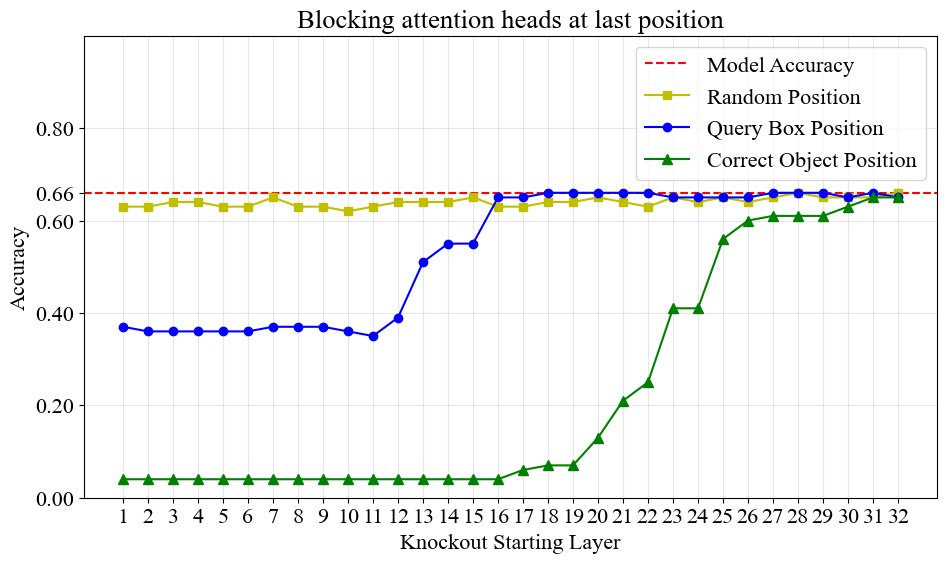

In [13]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

# Increase figure size
plt.rcParams["figure.figsize"] = [11, 6]

plt.axhline(y=0.66, color="r", linestyle="--", linewidth=1.5, label="Model Accuracy")
plt.plot(
    list(acc_random_pos.keys()),
    list(acc_random_pos.values()),
    "s-",
    color="y",
    linewidth=1.5,
    markersize=6,
    label="Random Position",
)
plt.plot(
    list(acc_query_box_pos.keys()),
    list(acc_query_box_pos.values()),
    "o-",
    color="b",
    linewidth=1.5,
    markersize=6,
    label="Query Box Position",
)
plt.plot(
    list(acc_correct_obj_pos.keys()),
    list(acc_correct_obj_pos.values()),
    "^-",
    color="g",
    linewidth=1.5,
    markersize=7,
    label="Correct Object Position",
)

plt.xlabel("Knockout Starting Layer")
plt.ylabel("Accuracy")
plt.title("Blocking attention heads at last position")

# Annotate horizontal line with text
# plt.annotate(
#     "Model Accuracy",
#     xy=(0, 0.66),  # The point (knockout_layer, 0.66) to annotate
#     xytext=(0, 0.7),  # Position of text
# )

plt.ylim(0, 1)

ticks = [round(i / 10, 1) for i in range(0, 10, 2)]
ticks.append(0.66)
plt.yticks(ticks)

plt.xticks([i for i in range(0, 32, 1)])
plt.legend(loc="upper right")

# Add grid
plt.grid(alpha=0.3)

# plt.show()
plt.savefig("figures/last_pos.pdf", dpi=300, bbox_inches="tight")

## Knocking out attention from query box to previous query box position

In [8]:
accuracies = defaultdict(float)
for knockout_layer in range(0, model.config.num_hidden_layers):
    modules = [
        [
            f"model.layers.{i}.self_attn.k_proj",
            f"model.layers.{i}.self_attn.q_proj",
            f"model.layers.{i}.self_attn.v_proj",
            f"model.layers.{i}.self_attn.o_proj",
        ]
        for i in range(knockout_layer, model.config.num_hidden_layers)
    ]

    modules = [item for sublist in modules for item in sublist]
    queries, keys, attn_outputs = {}, {}, {}

    model.eval()
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, input in enumerate(dataloader):
            for k, v in input.items():
                if v is not None and isinstance(v, torch.Tensor):
                    input[k] = v.to(model.device)

            batch_size, seq_len = input["input_ids"].shape
            prev_box_label_index = compute_prev_query_box_pos(
                input["input_ids"][0], input["last_token_indices"][0]
            )

            with TraceDict(
                model,
                modules,
                retain_output=True,
                edit_output=intervention_wrapper(
                    batch_size,
                    seq_len,
                    from_pos=input["last_token_indices"][0] - 2,
                    to_pos=prev_box_label_index,
                ),
            ) as _:
                outputs = model(input_ids=input["input_ids"])

            for bi in range(input["labels"].size(0)):
                label = input["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][input["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    accuracies[knockout_layer+1] = round(correct_count / total_count, 2)

    print(f"Knockout Starting Layer {knockout_layer} acc: {accuracies[knockout_layer+1]}")

Knockout Starting Layer 0 acc: 0.05
Knockout Starting Layer 1 acc: 0.05
Knockout Starting Layer 2 acc: 0.09
Knockout Starting Layer 3 acc: 0.09
Knockout Starting Layer 4 acc: 0.09
Knockout Starting Layer 5 acc: 0.13
Knockout Starting Layer 6 acc: 0.14
Knockout Starting Layer 7 acc: 0.19
Knockout Starting Layer 8 acc: 0.32


In [ ]:
with open("results/from_query_box_to_prev_query_box.json", "w") as f:
    json.dump(accuracies, f)

## Knocking out attention from query box to random position

In [9]:
accuracies = defaultdict(float)
for knockout_layer in range(0, model.config.num_hidden_layers):
    modules = [
        [
            f"model.layers.{i}.self_attn.k_proj",
            f"model.layers.{i}.self_attn.q_proj",
            f"model.layers.{i}.self_attn.v_proj",
            f"model.layers.{i}.self_attn.o_proj",
        ]
        for i in range(knockout_layer, model.config.num_hidden_layers)
    ]

    modules = [item for sublist in modules for item in sublist]
    queries, keys, attn_outputs = {}, {}, {}

    model.eval()
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, input in enumerate(dataloader):
            for k, v in input.items():
                if v is not None and isinstance(v, torch.Tensor):
                    input[k] = v.to(model.device)

            batch_size, seq_len = input["input_ids"].shape
            # Selecting random position in the prompt context (not in the query)
            to_pos = random.randint(0, seq_len - 4)

            with TraceDict(
                model,
                modules,
                retain_output=True,
                edit_output=intervention_wrapper(
                    batch_size,
                    seq_len,
                    from_pos=input["last_token_indices"][0] - 2,
                    to_pos=to_pos,
                ),
            ) as _:
                outputs = model(input_ids=input["input_ids"])

            for bi in range(input["labels"].size(0)):
                label = input["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][input["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    accuracies[knockout_layer+1] = round(correct_count / total_count, 2)

    print(f"Knockout Starting Layer {knockout_layer} acc: {accuracies[knockout_layer+1]}")

Knockout Starting Layer 0 acc: 0.62
Knockout Starting Layer 1 acc: 0.63
Knockout Starting Layer 2 acc: 0.61
Knockout Starting Layer 3 acc: 0.64
Knockout Starting Layer 4 acc: 0.63
Knockout Starting Layer 5 acc: 0.62
Knockout Starting Layer 6 acc: 0.63
Knockout Starting Layer 7 acc: 0.64
Knockout Starting Layer 8 acc: 0.64
Knockout Starting Layer 9 acc: 0.65
Knockout Starting Layer 10 acc: 0.65
Knockout Starting Layer 11 acc: 0.65
Knockout Starting Layer 12 acc: 0.66
Knockout Starting Layer 13 acc: 0.65
Knockout Starting Layer 14 acc: 0.65
Knockout Starting Layer 15 acc: 0.66
Knockout Starting Layer 16 acc: 0.66
Knockout Starting Layer 17 acc: 0.66
Knockout Starting Layer 18 acc: 0.66
Knockout Starting Layer 19 acc: 0.66
Knockout Starting Layer 20 acc: 0.66
Knockout Starting Layer 21 acc: 0.66
Knockout Starting Layer 22 acc: 0.66
Knockout Starting Layer 23 acc: 0.66
Knockout Starting Layer 24 acc: 0.66
Knockout Starting Layer 25 acc: 0.66
Knockout Starting Layer 26 acc: 0.66
Knockout St

In [10]:
with open("results/from_query_box_to_random_pos.json", "w") as f:
    json.dump(accuracies, f)

## Visualization Information Flow from Query Box Position

In [2]:
acc_prev_query_box_pos = json.load(open("results/from_query_box_to_prev_query_box.json"))
acc_random_pos = json.load(open("results/from_query_box_to_random_pos.json"))

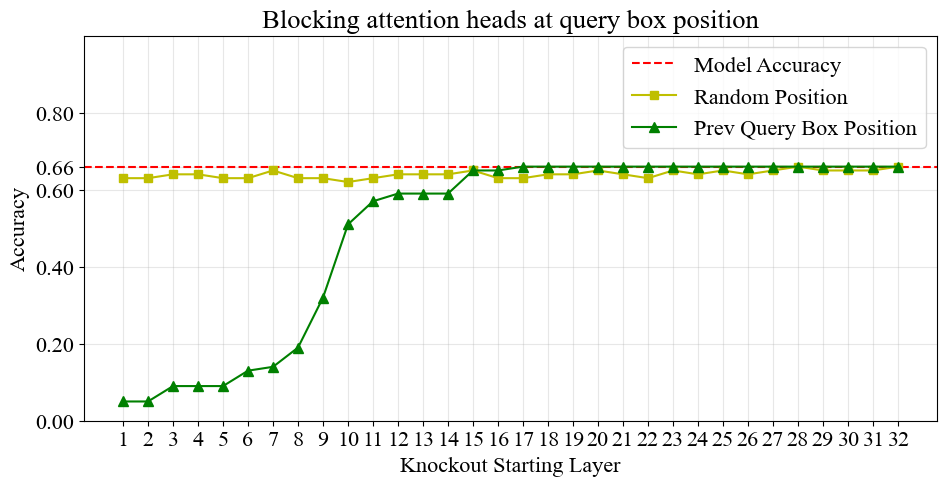

In [15]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

# Increase figure size
plt.rcParams["figure.figsize"] = [11, 5]

plt.axhline(y=0.66, color="r", linestyle="--", linewidth=1.5, label="Model Accuracy")
plt.plot(
    list(acc_random_pos.keys()),
    list(acc_random_pos.values()),
    "s-",
    color="y",
    linewidth=1.5,
    markersize=6,
    label="Random Position",
)
plt.plot(
    list(acc_prev_query_box_pos.keys()),
    list(acc_prev_query_box_pos.values()),
    "^-",
    color="g",
    linewidth=1.5,
    markersize=7,
    label="Prev Query Box Position",
)

plt.xlabel("Knockout Starting Layer")
plt.ylabel("Accuracy")
plt.title("Blocking attention heads at query box position")

plt.ylim(0, 1)

ticks = [round(i / 10, 1) for i in range(0, 10, 2)]
ticks.append(0.66)
plt.yticks(ticks)

plt.xticks([i for i in range(0, 32, 1)])
plt.legend(loc="upper right")

# Add grid
plt.grid(alpha=0.3)

# plt.show()
plt.savefig("figures/query_box_pos.pdf", dpi=300, bbox_inches="tight")